In [ ]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit
import warnings
import json
from helper_functions import find_dips, find_index
from wafer_plot import draw_wafer_plot

warnings.filterwarnings('ignore')

In [5]:
def lin_func(x, a):
    return a * x

In [35]:
root_path = Path('/Users/jiahaozhan/Google Drive/Other Computers/CM300/Dione_wafer3_BO')
data_path = root_path / 'pdk_thermphase_test_cells'

no = 1
data_dir_gen = sorted(data_path.glob(f'reticle27/*.json'))
for d in data_dir_gen:
    df = pd.read_json(d)
    # print(df.columns)
    # print(df['wavelength'])
    # ret = int(df['reticle'][0])
    
    wavel = df['wavelength'][no]
    trans = df['transmission_ch1'][no]
    volts = df['smu_voltage'][no]
    currs = df['smu_current'][no]

currs = [i - currs[0] for i in currs] # current should be 0 at 0 V
currs_mA = np.multiply(currs, 1000)

elec_pwrs = np.multiply(volts, currs_mA)
res = np.divide(volts[1:], currs[1:])

print(currs_mA)
print(res)

[ 0.         3.9624808  7.8851448 11.8220018 15.6320218 19.3890818
 23.0818818 26.6913718 30.3240218 33.7394118 37.0514418 40.2619818
 43.3654418 46.4572118 49.3389718 52.1235718 54.7866318 57.3475118
 59.8025818 62.2413918 64.4951918 66.6573018 68.7281718 70.7173818
 72.6771818 74.4911618]
[25.23671534 25.36415057 25.37641299 25.58850065 25.78770904 25.99441437
 26.22570339 26.38172487 26.67503528 26.98950301 27.32105949 27.67180386
 27.9827383  28.37513529 28.77776691 29.20420452 29.64383191 30.09903496
 30.52630966 31.01006361 31.50442552 32.01016326 32.52382853 33.02274442
 33.56102844]


(1310.0, 1317.5)

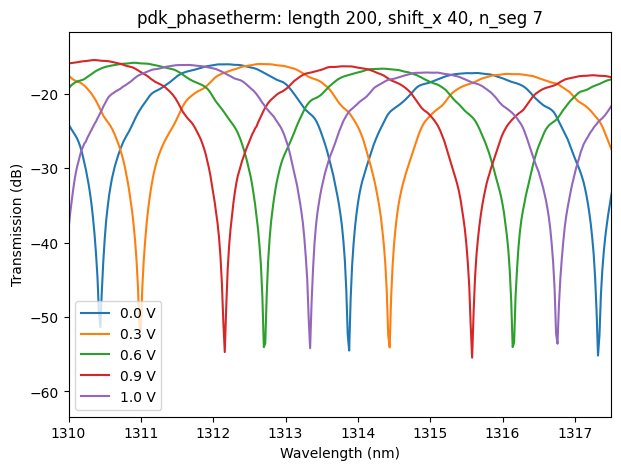

In [36]:
# plot tranmission spectra at different voltages
title = f"pdk_phasetherm: length {df['length'][no]}, shift_x {df['shift_x'][no]}, n_seg {df['n_seg'][no]}"
xlim = [1310, 1315.1]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for i in [0,3,6,9,10]:
    ax.plot(wavel, trans[i], label=f'{volts[i]:.2} V')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Transmission (dB)')
ax.set_title(title)
ax.legend()
ax.set_xlim([1310, 1317.5])
# ax.text(xlim[1]-2, -61, '$P_{\pi}$ = ' + f'{P_pi:.2f} mW', fontsize=12)

[[1310.4327703272006, 1313.8719505733857, 1317.3292823913787], [1310.4811603266044, 1313.9236563022694, 1317.3796256411647], [1310.6674245458344, 1314.1085567971143], [1310.9898442378276, 1314.4293393768712], [1311.4398523432642, 1314.8698141774307], [1312.0113204542486, 1315.4399838759437], [1312.7064265285007, 1316.1482052786437], [1310.107921263231, 1313.536939194237, 1316.9675172658121], [1311.0884005353305, 1314.518427932115], [1312.1549458356062, 1315.5766157927455]]


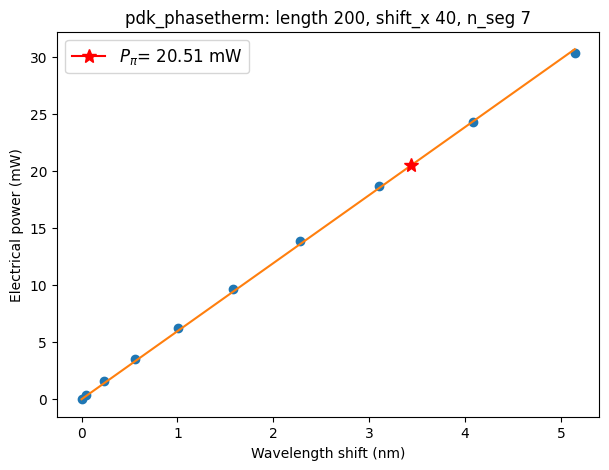

In [37]:
# Calculate FSR
# wavel[950] -> 1309 nm, wavel[1300] -> 1316 nm
l_id, u_id = find_index(1310, wavel), find_index(1317.5, wavel)
v_u_id = 10

dips_0V = find_dips(wavel[l_id:u_id], trans[0][l_id:u_id], -40)
FSR = dips_0V[1] - dips_0V[0]
wavel_ref = dips_0V[0]

dips = []
for i in range(v_u_id):
    dips.append(find_dips(wavel[l_id:u_id], trans[i][l_id:u_id], -40))
print(dips)

dip = []
for i in range(v_u_id):
    # print(i)
    # print(dip)
    if i == 0:
        dip.append(dips[0][0])
        continue
    for d in dips[i]:
        if d > dip[i-1]:
            dip.append(d)
            break
            
wavel_shift = np.array([w - dip[0] for w in dip])
p_opt, p_cov = curve_fit(lin_func, wavel_shift, elec_pwrs[:v_u_id])
P_pi = lin_func(FSR, *p_opt)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(wavel_shift, elec_pwrs[:v_u_id], 'o')
ax.plot(wavel_shift, lin_func(wavel_shift, *p_opt))
ax.plot(FSR, P_pi, marker='*', markersize=10, color='r', label='$P_{\pi}$' + f'= {P_pi:.2f} mW')
ax.set_ylabel('Electrical power (mW)')
ax.set_xlabel('Wavelength shift (nm)')
ax.set_title(title)
ax.legend(prop={'size':12})
# ax.set_xlim([1309, 1316])